# Fáza 3 - strojové učenie

Dávid Kromka, Jozef Kyška Podiel práce 50% : 50% Cvičenie pondelok 11:00 Dataset 23

In [23]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn
plt.rcParams['figure.figsize'] = 15, 10

In [24]:
filename = "train.csv"
filename2 = "test.csv"
train = pd.read_csv(filename)
test = pd.read_csv(filename2)
print(train.head())
print(test.head())

      etytr     hbver  leukocyty  hematokrit  indicator
0 -0.399628 -1.673183  -1.272179    0.584718        1.0
1  0.309280  0.461772   1.262083    0.101565        1.0
2 -1.065034  0.592658  -0.350652   -1.020035        0.0
3  1.073037  0.705458   0.166171   -0.330980        1.0
4 -1.375606  0.194146  -0.998064   -0.225887        1.0
     etytr    hbver  leukocyty  hematokrit  indicator
0  5.82281  8.58058    7.55633     5.04757        0.0
1  5.65706  7.43965   10.09821     6.06325        0.0
2  8.11379  9.91181    7.74704     8.84160        1.0
3  5.34681  9.96587    6.18617     8.29191        1.0
4  8.54295  6.65051    8.81665     5.28312        0.0


In [25]:
print(train.shape)
print(test.shape)

(7669, 5)
(1918, 5)


## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

OneR alebo "One rule" je jednoduchý klasifikačný algorutmus pre suprevised learning. Pre každú hodnotu feature zo 
všetkých features a ich indikátora generuje pravidlo a vyberá také, ktoré má najmenší total error. Pre vytvorenie pravidla musíme najprv
vytvoriť tabuľku počtov hodnôt atributov pre danú hodnotu indikatora a následne vytvoríme pravidlá pre najčastejsiu hodnotu indikátora.

In [26]:
trainq = train
n=10
trainq['etytr'] = pd.qcut(train['etytr'], n, labels=False)
trainq['hbver'] = pd.qcut(train['hbver'], n, labels=False)
trainq['leukocyty'] = pd.qcut(train['leukocyty'], n, labels=False)
trainq['hematokrit'] = pd.qcut(train['hematokrit'], n, labels=False)

testq = test
testq['etytr'] = pd.qcut(test['etytr'], n, labels=False)
testq['hbver'] = pd.qcut(test['hbver'], n, labels=False)
testq['leukocyty'] = pd.qcut(test['leukocyty'], n, labels=False)
testq['hematokrit'] = pd.qcut(test['hematokrit'], n, labels=False)
print(trainq)
print(testq)

      etytr  hbver  leukocyty  hematokrit  indicator
0         3      0          1           7        1.0
1         6      6          8           5        1.0
2         1      7          3           1        0.0
3         8      7          5           3        1.0
4         0      5          1           3        1.0
...     ...    ...        ...         ...        ...
7664      2      0          0           3        1.0
7665      1      9          5           2        0.0
7666      8      6          9           2        1.0
7667      8      7          4           6        1.0
7668      1      9          6           1        0.0

[7669 rows x 5 columns]
      etytr  hbver  leukocyty  hematokrit  indicator
0         2      5          5           0        0.0
1         1      2          9           1        0.0
2         6      8          6           7        1.0
3         1      9          2           5        1.0
4         7      0          8           0        0.0
...     ...    ...   

In [27]:
x_train = trainq.drop('indicator', axis=1)
x_test = test.drop('indicator', axis=1)
print(x_train)
print(x_test)

      etytr  hbver  leukocyty  hematokrit
0         3      0          1           7
1         6      6          8           5
2         1      7          3           1
3         8      7          5           3
4         0      5          1           3
...     ...    ...        ...         ...
7664      2      0          0           3
7665      1      9          5           2
7666      8      6          9           2
7667      8      7          4           6
7668      1      9          6           1

[7669 rows x 4 columns]
      etytr  hbver  leukocyty  hematokrit
0         2      5          5           0
1         1      2          9           1
2         6      8          6           7
3         1      9          2           5
4         7      0          8           0
...     ...    ...        ...         ...
1913      0      0          9           3
1914      6      7          7           9
1915      7      6          1           8
1916      5      7          5           0
1917     

In [28]:
y_train = trainq['indicator']
y_test = test['indicator']
print(f'y_train size: {y_train.shape[0]}')
print(f'y_test size: {y_test.shape[0]}')

y_train size: 7669
y_test size: 1918


In [29]:
def get_rule_for_column(column, indicator):
    rules = []
    total_error = 0
    column_indicator = pd.DataFrame({'attribute': column, 'indicator': indicator})
    
    for value in column.unique():
        
        records_of_value = column_indicator[column_indicator['attribute'] == value]
        value_counts = records_of_value['indicator'].value_counts()
        indicator_0_count = value_counts[0.0]
        indicator_1_count = value_counts[1.0]
        
        if indicator_0_count > indicator_1_count:
            rules.append(0.0)
            total_error = total_error + indicator_1_count
        else:
            rules.append(1.0)
            total_error = total_error + indicator_0_count
    
    return rules, total_error


def oneR_fit(x_train, y_train):
    smallest_error = np.inf
    
    for col in x_train.columns:
        rules, error = get_rule_for_column(x_train[col], y_train)
        if error < smallest_error:
            best_attribute = col
            best_rules = rules
            smallest_error = error
    
    return best_rules, best_attribute


def oneR_predict(rules, attribute, x_test):
    column = x_test[attribute]
    predictions = []
    
    for value in column:
        prediction = rules[value]
        predictions.append(prediction)
        
    return predictions


rules, attribute = oneR_fit(x_train, y_train)
print(accuracy_score(y_test, oneR_predict(rules, attribute, x_test)))
print(precision_score(y_test, oneR_predict(rules, attribute, x_test)))
print(recall_score(y_test, oneR_predict(rules, attribute, x_test)))

0.5891553701772679
0.6421121251629727
0.8047385620915033


## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia

[Text(418.5, 475.65000000000003, 'X[3] <= 0.5\ngini = 0.457\nsamples = 7669\nvalue = [2712, 4957]'),
 Text(209.25, 339.75, 'X[2] <= 1.5\ngini = 0.411\nsamples = 1918\nvalue = [1364, 554]'),
 Text(104.625, 203.85000000000002, 'X[0] <= 1.5\ngini = 0.492\nsamples = 717\nvalue = [312, 405]'),
 Text(52.3125, 67.94999999999999, 'gini = 0.394\nsamples = 523\nvalue = [141, 382]'),
 Text(156.9375, 67.94999999999999, 'gini = 0.209\nsamples = 194\nvalue = [171, 23]'),
 Text(313.875, 203.85000000000002, 'X[0] <= 2.5\ngini = 0.217\nsamples = 1201\nvalue = [1052, 149]'),
 Text(261.5625, 67.94999999999999, 'gini = 0.142\nsamples = 1092\nvalue = [1008, 84]'),
 Text(366.1875, 67.94999999999999, 'gini = 0.481\nsamples = 109\nvalue = [44, 65]'),
 Text(627.75, 339.75, 'X[2] <= 2.5\ngini = 0.359\nsamples = 5751\nvalue = [1348, 4403]'),
 Text(523.125, 203.85000000000002, 'X[0] <= 1.5\ngini = 0.401\nsamples = 4480\nvalue = [1243, 3237]'),
 Text(470.8125, 67.94999999999999, 'gini = 0.276\nsamples = 2264\nvalu

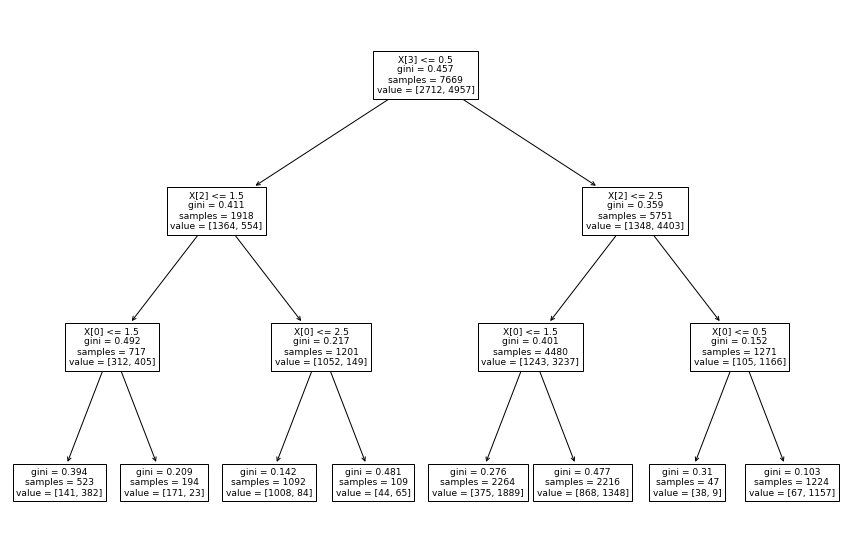

In [503]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_train, y_train)

tree.plot_tree(clf)

In [504]:
accuracy_score(y_test, clf.fit(x_train, y_train).predict(x_test))

0.7778936392075079

In [505]:
precision_score(y_test, clf.fit(x_train, y_train).predict(x_test))

0.752851711026616

In [506]:
recall_score(y_test, clf.fit(x_train, y_train).predict(x_test))

0.9705882352941176

[Text(412.79571143617017, 509.625, 'X[3] <= 0.5\ngini = 0.457\nsamples = 7669\nvalue = [2712, 4957]'),
 Text(206.74567819148936, 441.675, 'X[2] <= 1.5\ngini = 0.411\nsamples = 1918\nvalue = [1364, 554]'),
 Text(116.86835106382978, 373.725, 'X[0] <= 1.5\ngini = 0.492\nsamples = 717\nvalue = [312, 405]'),
 Text(71.23404255319149, 305.775, 'X[1] <= 1.5\ngini = 0.394\nsamples = 523\nvalue = [141, 382]'),
 Text(35.61702127659574, 237.825, 'X[1] <= 0.5\ngini = 0.186\nsamples = 357\nvalue = [37, 320]'),
 Text(17.80851063829787, 169.875, 'X[2] <= 0.5\ngini = 0.058\nsamples = 236\nvalue = [7, 229]'),
 Text(8.904255319148936, 101.92500000000001, 'X[0] <= 0.5\ngini = 0.013\nsamples = 153\nvalue = [1, 152]'),
 Text(4.452127659574468, 33.97500000000002, 'gini = 0.02\nsamples = 100\nvalue = [1, 99]'),
 Text(13.356382978723403, 33.97500000000002, 'gini = 0.0\nsamples = 53\nvalue = [0, 53]'),
 Text(26.712765957446805, 101.92500000000001, 'X[0] <= 0.5\ngini = 0.134\nsamples = 83\nvalue = [6, 77]'),
 Te

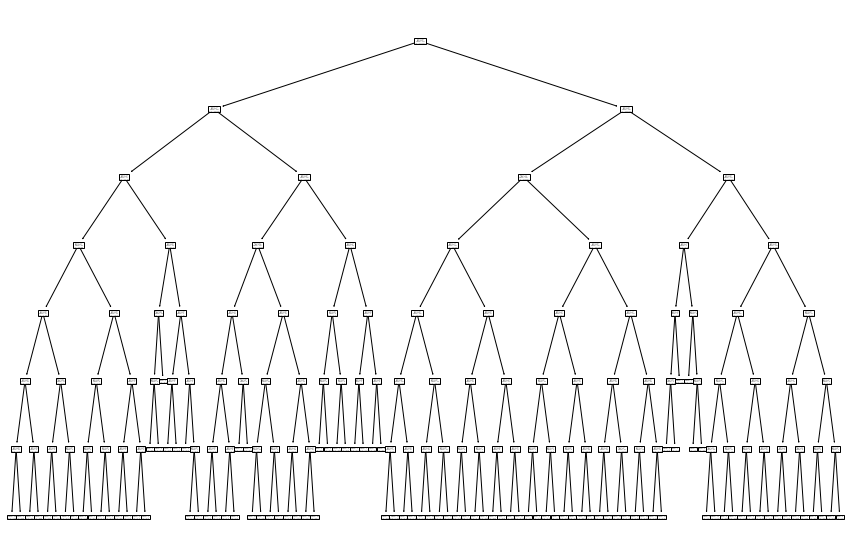

In [507]:
clf2 = tree.DecisionTreeClassifier(max_depth=7)
clf2 = clf2.fit(x_train, y_train)

tree.plot_tree(clf2)

In [508]:
accuracy_score(y_test, clf2.fit(x_train, y_train).predict(x_test))

0.8733055265901981

In [509]:
precision_score(y_test, clf2.fit(x_train, y_train).predict(x_test))

0.882903981264637

In [510]:
recall_score(y_test, clf2.fit(x_train, y_train).predict(x_test))

0.9240196078431373

In [132]:
from sklearn.tree import DecisionTreeClassifier

results = []
estimators = []
for i in range(1, x_train.shape[1] +1):  
    row = {'model_complexity': i}
    
    clf = DecisionTreeClassifier(max_depth = i) 
    
    pred = clf.fit(x_train, y_train).predict(x_train) 
    
    row['train'] = 1-accuracy_score(y_train, pred) 
    print(accuracy_score(y_train, pred))
    
    pred = clf.predict(x_test)
    
    row['test'] = 1-accuracy_score(y_test, pred) 
    print(accuracy_score(y_test, pred))
    results.append(row)
    estimators.append(clf)

0.7543356369800496
0.735140771637122
0.762420133002999
0.751303441084463
0.7926717955404877
0.7904066736183525
0.8424827226496284
0.8326381647549531


In [512]:
complexity_df = pd.DataFrame(results)
complexity_df.head()

,model_complexity,train,test
0,1,0.248011,0.258603
1,2,0.235885,0.246611
2,3,0.210067,0.222106
3,4,0.165732,0.171011


<AxesSubplot:xlabel='model_complexity'>

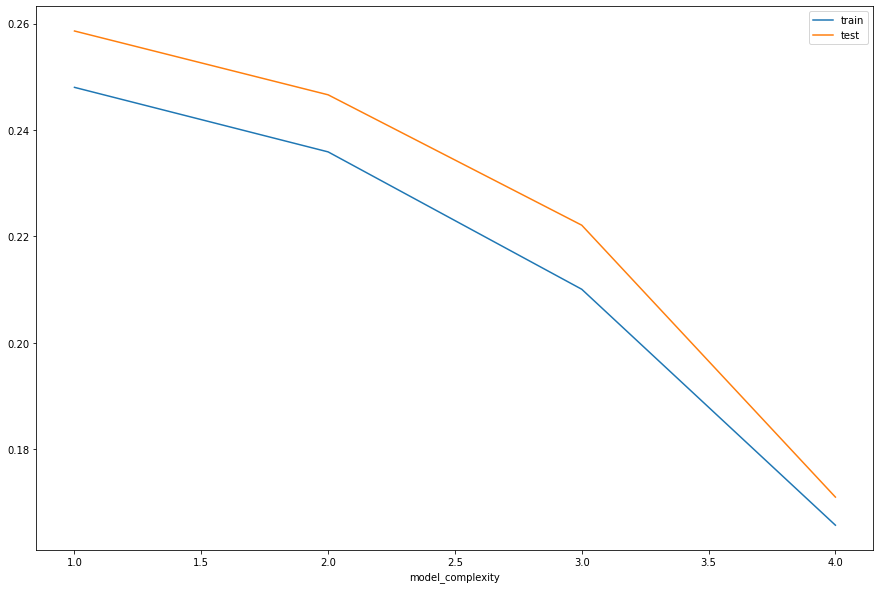

In [513]:
complexity_df.plot(x='model_complexity')

S rastúcou zložitosťou sa na trenovacej množine sa chyba znižuje o niečo viac ako pri testovacej množine až sa zmenšovať prestane. Znamená to, že takýto model je preučený a na trénovacej množine bude fungovať, no s inými dátami nie. Stačí nám jednoduchší model.

Výsledky modelu, ktorý bol vytvorený našim OneR algoritmom sú horšie ako výsledky modelu vytvoreného pomocou DecisionTreeClassifier z knižnice sklearn.

## 3. Optimalizácia - hyperparameter tuning

Veľký vplyv na výsledky decision tree algoritmu z druhého kroku môžu mať hyperparametre. V tejto časti budeme nastavovať parametre tak, aby sme predišli overfittingu a dostali čo najviac optimálny model. Venujeme sa nastavenie parametrov max_depth, min_samples_split, min_samples_leaf, random_state a criterion. 

In [136]:
def evaluate_model(classifier):
    print("Train Accuracy :", accuracy_score(y_train, classifier.predict(x_train)))
    print("Train Precision", precision_score(y_train, classifier.predict(x_train)))
    print("Train Recall", recall_score(y_train, classifier.predict(x_train)))
    print("Test Accuracy :", accuracy_score(y_test, classifier.predict(x_test)))
    print("Test Precision", precision_score(y_test, classifier.predict(x_test)))
    print("Test Recall", recall_score(y_test, classifier.predict(x_test)))
    

In [141]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(max_depth = 7)
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
confusion_matrix(y_train, y_train_pred)

0.8965966879645325
0.881126173096976


array([[2235,  477],
       [ 316, 4641]], dtype=int64)

In [555]:
print(accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)

0.8733055265901981


array([[ 544,  150],
       [  93, 1131]], dtype=int64)

Random_state riadi náhodnosť v rámci odhadu a defaultne je nastavený na None. Funkcie sú vždy náhodne permutované pri každom rozdelení, aj keď je splitter nastavený na „best“.

In [556]:
# random state
model_r = DecisionTreeClassifier(random_state=10)
model_r.fit(x_train, y_train)

DecisionTreeClassifier(random_state=10)

In [557]:
evaluate_model(model_r)
print(cross_val_score(model_r, x_test, y_test, cv=3))

Train Accuracy : 0.888512191941583
Train Precision 0.9031053459119497
Train Recall 0.9269719588460763
Test Accuracy : 0.8806047966631908
Test Precision 0.8932806324110671
Test Recall 0.923202614379085
[0.85       0.87793427 0.86697966]


max_depth predstavuje maximálnu hĺbku stromu. Ak nie je nastavená, uzly sa rozšírujú, až kým nie sú všetky uzly čisté alebo kým neobsahujú menej niž min_samples_split vzoriek.

In [558]:
# depth
model_d = DecisionTreeClassifier(max_depth=3)
model_d.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [559]:
evaluate_model(model_d)
print(cross_val_score(model_d, x_test, y_test, cv=3))

Train Accuracy : 0.7899334985004564
Train Precision 0.7640467171717171
Train Recall 0.9765987492434941
Test Accuracy : 0.7778936392075079
Test Precision 0.752851711026616
Test Recall 0.9705882352941176
[0.7765625  0.81064163 0.79968701]


min_samples_split: Minimálny počet vzoriek požadovaných na rozdelenie vnútorného uzla, deafultne je nastavený na 2.

In [560]:
model_ms = DecisionTreeClassifier(min_samples_split=10)
model_ms.fit(x_train, y_train)
print(cross_val_score(model_ms, x_test, y_test, cv=3))

[0.871875   0.87793427 0.87010955]


In [561]:
evaluate_model(model_ms)

Train Accuracy : 0.8882514017472943
Train Precision 0.9029088050314465
Train Recall 0.9267702239257616
Test Accuracy : 0.8800834202294057
Test Precision 0.8925750394944708
Test Recall 0.923202614379085


min_samples_leaf: Minimálny počet vzoriek požadovaný na to, aby bol vytvorený list. Bod rozdelenia v akejkoľvek hĺbke sa bude brať do úvahy iba vtedy, ak ponecháva aspoň min_samples_leaf z tréningovej vzorky v každej v ľavej aj pravej vetve. 

In [562]:
model_ml = DecisionTreeClassifier(min_samples_leaf=25, random_state=10)
model_ml.fit(x_train, y_train)
print(cross_val_score(model_ml, x_test, y_test, cv=3))

[0.8        0.81377152 0.82942097]


In [563]:
evaluate_model(model_ml)

Train Accuracy : 0.8746903116442821
Train Precision 0.8916111328890631
Train Recall 0.9176921525115997
Test Accuracy : 0.8722627737226277
Test Precision 0.8857368006304176
Test Recall 0.9183006535947712


criterion: entropy alebo gini, je to funkcia na meranie kvality rozdelenia.

In [564]:
model_en = DecisionTreeClassifier(max_depth=7, min_samples_leaf=20, random_state=10, criterion="entropy")
model_en.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=20,
                       random_state=10)

In [565]:
evaluate_model(model_en)
print(cross_val_score(model_en, x_test, y_test, cv=3))

Train Accuracy : 0.8726039900899726
Train Precision 0.8898902821316614
Train Recall 0.9162800080693968
Test Accuracy : 0.8660062565172054
Test Precision 0.8834258524980174
Test Recall 0.9101307189542484
[0.8125     0.84663537 0.82942097]


In [140]:
from sklearn.model_selection import GridSearchCV
variants = {
    'max_depth': [2, 3, 5, 7, 10, 25, 35],
    'min_samples_leaf': [1, 3, 5, 10, 20, 50],
    'criterion': ["gini", "entropy"],
    'min_samples_split': [2, 3, 5, 10, 20],
    'random_state': [None, 1, 2, 5, 10, 20, 40, 50]
}
def grid(clf, x_train, y_train):
    grid_search = GridSearchCV(estimator=clf, 
                               param_grid=variants, 
                               cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

    grid_search.fit(x_train, y_train)
    score = pd.DataFrame(grid_search.cv_results_)
    model_best = grid_search.best_estimator_
    return score, model_best
score, model_best = grid(clf, x_train, y_train)
score.head()

Fitting 5 folds for each of 3360 candidates, totalling 16800 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007635,0.003022,0.002763,0.002938,gini,2,1,2,None,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.773794,0.765319,0.752934,0.752934,0.767123,0.762421,0.008245,2881
1,0.008641,0.001253,0.001910,0.001695,gini,2,1,2,1,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.773794,0.765319,0.752934,0.752934,0.767123,0.762421,0.008245,2881
2,0.006891,0.004894,0.005231,0.003532,gini,2,1,2,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.773794,0.765319,0.752934,0.752934,0.767123,0.762421,0.008245,2881
3,0.007778,0.000978,0.003365,0.000977,gini,2,1,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.773794,0.765319,0.752934,0.752934,0.767123,0.762421,0.008245,2881
4,0.006816,0.002710,0.002710,0.002969,gini,2,1,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.773794,0.765319,0.752934,0.752934,0.767123,0.762421,0.008245,2881


In [567]:
score.nlargest(10,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1040,0.012566,0.002570,0.002393,0.000488,gini,10,5,2,None,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1
1041,0.007979,0.000891,0.002624,0.000515,gini,10,5,2,1,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1
1042,0.012536,0.006272,0.002194,0.000398,gini,10,5,2,2,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1
1043,0.009574,0.002239,0.002195,0.000399,gini,10,5,2,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1
1044,0.009375,0.002410,0.002194,0.000399,gini,10,5,2,10,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1
1045,0.008777,0.000399,0.002194,0.000399,gini,10,5,2,20,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1
1046,0.008177,0.000399,0.002394,0.000489,gini,10,5,2,40,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1
1047,0.010970,0.002274,0.002394,0.000488,gini,10,5,2,50,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1
1048,0.007981,0.000632,0.002790,0.000747,gini,10,5,3,None,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1
1049,0.010771,0.002309,0.002794,0.000398,gini,10,5,3,1,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.878096,0.885919,0.891786,0.874837,0.883888,0.882905,0.005952,1


In [568]:
# zatiaľ najlepší model
evaluate_model(model_best)
print(cross_val_score(model_best, x_test, y_test, cv=3))

Train Accuracy : 0.8881210066501499
Train Precision 0.9028897188912915
Train Recall 0.9265684890054469
Test Accuracy : 0.8800834202294057
Test Precision 0.8925750394944708
Test Recall 0.923202614379085
[0.86875    0.88419405 0.87167449]


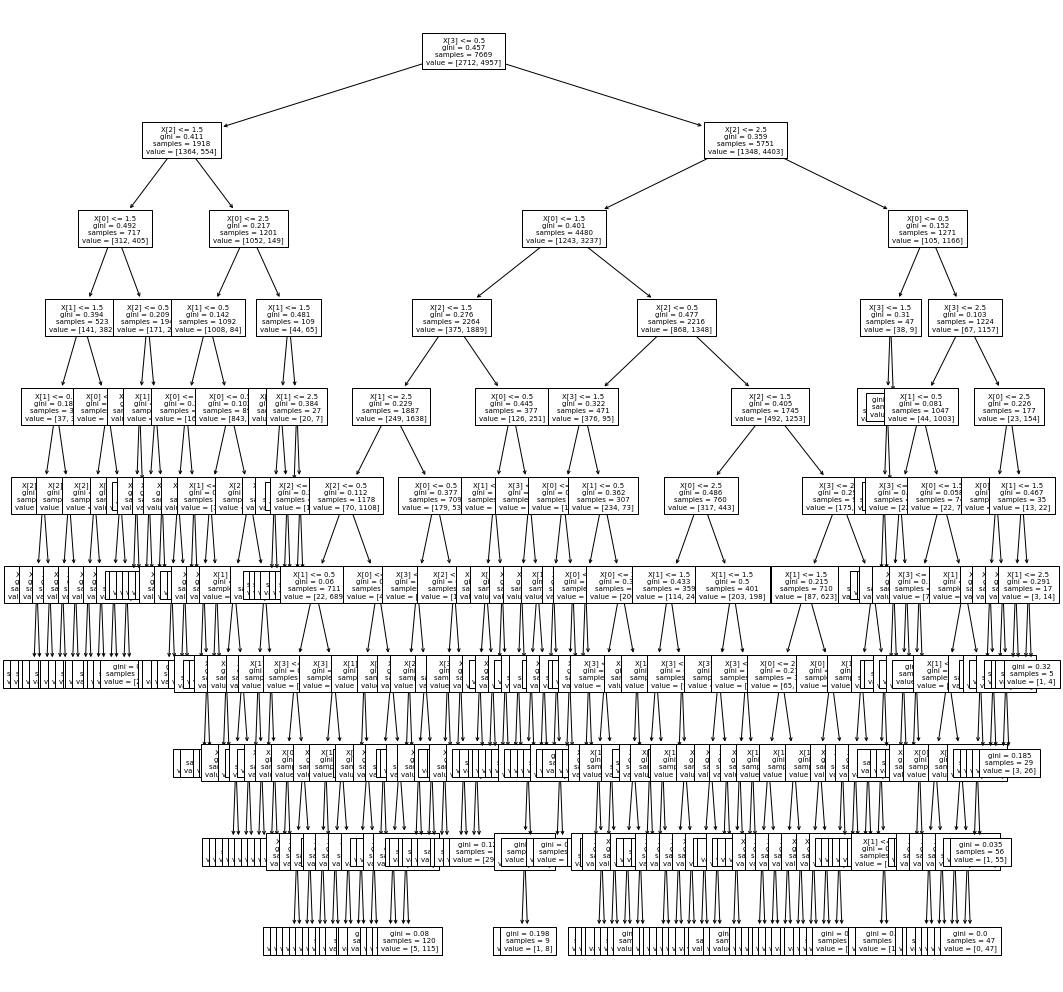

In [586]:
plt.figure(figsize=(18,18))
tree.plot_tree(model_best, fontsize=7)
plt.show()

## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

Veľký vplyv na presnosť má stratégia riešenia chýbajúcich a vychýlených hodnôt. Najlepšie výsledky sú pri odstránení NAN hodnôt, pri nahradení priemerom, mediánom alebo pomocou KNN imputer boli výsledky horšie. Na druhom mieste po odstranení je stratégia doplnenia chýbajúcich hodnôt mediánom, následne priemerom a ďalšia je KNN imputer.

Najlepšia stratégia zaobchádzania s vychýlenými hodnotami je ich odstránenie, druhý vyskúšaný spôsob nahradenie vychýlených hodnôt hraničnými hodnotami priniesol slabšie výsledky.

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [121]:
filename = "data.csv"
data = pd.read_csv(filename)
data.head()

,hemoglobin,etytr,hbver,smoker,alt,trombocyty,erytrocyty,leukocyty,relationship,indicator,hematokrit,alp,ast,er-cv,blood_group,race,sex,birthdate
0,8.04859,8.33134,6.92033,0,5.32060,9.02598,7.77355,6.19725,1,1.0,8.42675,40.67505,65.03438,57.03521,2,2,0,34593
1,7.06975,5.87075,7.55645,1,3.00974,8.16432,6.61407,8.12903,3,0.0,5.20481,80.56262,78.69936,49.12368,2,2,0,34593
2,7.99925,8.50456,8.74478,1,6.86390,7.41719,8.10390,9.39205,3,1.0,8.05943,41.70678,73.50396,23.21061,2,2,0,34593
3,6.51314,9.25854,9.38356,1,4.11257,7.37351,7.33091,8.58102,1,1.0,8.36402,83.65217,69.74486,59.63760,3,1,1,37513
4,6.47968,5.81228,10.71625,0,2.88381,6.21111,5.73826,7.38472,5,1.0,9.81301,85.75254,57.14540,52.17063,3,1,1,37513


Pomocou funkcie make_model môžeme skúšať výsledky modelov s rôznymi parametrami, feature selection a stratégiami riešenia vychýlených hodnôt a chýbajúcich hodnôt.

In [135]:
def make_model(pipe, data, imputer):
    if imputer=='delete':
        data = data.dropna(axis=0)
    x = data.drop('indicator', axis=1)
    y = data['indicator']
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
    
    selector = pipe.fit(x_train, y_train)
    selected = pd.DataFrame({"attribute":list(x_train.columns), "selected": selector.named_steps["lr"].get_support()})
    print(selected)
    selected = selected[selected["selected"] == True]
    new_data_x = selector.transform(x_train)
    x_tr = pd.DataFrame(new_data_x, columns = selected['attribute'])
    y_tr = y_train.reset_index(drop=True)
    x_te = x_test
    
    if imputer!='delete':
        imputer_median = SimpleImputer(missing_values = np.nan, strategy =imputer)
        imputer_median = imputer_median.fit(x_test)
        x_te = pd.DataFrame(imputer_median.transform(x_test), columns = x_test.columns)

    test = pd.DataFrame()
    for name in selected['attribute']:
        test[name] = x_te[name]
    x_te = test
    y_te = y_test
    
    clf3 = DecisionTreeClassifier()
    clf3.fit(x_tr, y_tr)
    
    score, model_best = grid(clf3, x_tr, y_tr)
    print(score.nlargest(10,"mean_test_score"))
    print(cross_val_score(model_best, x_te, y_te, cv=3))
    return model_best
    

Nahradenie chýbajúcich hodnôt medianom, MinMaxScaler, SelectFromModel(estimator=LogisticRegression() bez ošetrenia vychýlených hodnôt.

In [134]:
make_model(Pipeline([('sm', SimpleImputer(missing_values = np.nan, strategy ='median')), ('mm', MinMaxScaler()), ('lr', SelectFromModel(estimator=LogisticRegression()))]), data, 'median')

       attribute  selected
0     hemoglobin     False
1          etytr      True
2          hbver      True
3         smoker     False
4            alt     False
5     trombocyty     False
6     erytrocyty     False
7      leukocyty      True
8   relationship     False
9     hematokrit      True
10           alp     False
11           ast     False
12         er-cv     False
13   blood_group     False
14          race     False
15           sex     False
16     birthdate     False
Fitting 5 folds for each of 3360 candidates, totalling 16800 fits
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3016       0.108327      0.009081         0.002992    4.422006e-07   
3002       0.106157      0.006437         0.002793    2.393707e-03   
3010       0.098137      0.003129         0.002992    4.422006e-07   
3018       0.126295      0.024911         0.002593    1.353007e-03   
3026       0.105718      0.012260         0.003391    3.313859e-03   
3034       0.109287      0.0

DecisionTreeClassifier(criterion='entropy', max_depth=25, min_samples_leaf=10,
                       min_samples_split=5)

Odstránenie chýbajúcich hodnôt, MinMaxScaler, SelectFromModel(estimator=LogisticRegression() bez ošetrenia vychýlených hodnôt.

In [543]:
make_model(Pipeline([('mm', MinMaxScaler()), ('lr', SelectFromModel(estimator=LogisticRegression()))]), data, 'delete')

       attribute  selected
0     hemoglobin     False
1          etytr      True
2          hbver      True
3         smoker     False
4            alt     False
5     trombocyty     False
6     erytrocyty     False
7      leukocyty      True
8   relationship     False
9     hematokrit      True
10           alp     False
11           ast     False
12         er-cv     False
13   blood_group     False
14          race     False
15           sex     False
16     birthdate     False
Fitting 5 folds for each of 3360 candidates, totalling 16800 fits
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1025       0.034978      0.004310         0.003208        0.003929   
1029       0.042233      0.004117         0.000000        0.000000   
1031       0.040222      0.000073         0.000000        0.000000   
1028       0.036623      0.003209         0.000399        0.000798   
1026       0.039014      0.000956         0.001207        0.000986   
1027       0.034960      0.0

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=10,
                       random_state=1)

In [138]:
# outliers detection
mean, std = np.mean(data), np.std(data)
out_range = 3 * std
lower, upper = mean - out_range, mean + out_range

outliers = []
data_out = []
data_border = []


def manage(row):
    for i in range(len(row)):
        if row[i] < lower.values[i]:
            row[i] = lower.values[i]
        elif  row[i] > upper.values[i]:
            row[i] = upper.values[i]
    return row

def outOutliers(data):
    for row in data.values:
        for i in range(len(row)):
            if row[i] < lower.values[i] or row[i] > upper.values[i]:
                outliers.append(row)
                data_border.append(manage(row))
                break
            else:
                if i == len(row) - 1:
                    data_out.append(row)
                    data_border.append(row)

outOutliers(data)
outliers = pd.DataFrame(outliers, columns = data.columns)
data_out = pd.DataFrame(data_out, columns = data.columns)
data_border = pd.DataFrame(data_border, columns = data.columns)
print(f'Počet vychýlených hodnôt: {outliers.shape[0]}, počet záznamov po odstránení vychýlených hodnôt: {data_out.shape[0]}.')

Počet vychýlených hodnôt: 412, počet záznamov po odstránení vychýlených hodnôt: 9588.


Odstránenie chýbajúcich hodnôt, MinMaxScaler, SelectFromModel(estimator=LogisticRegression(), odstránenie vychýlených hodnôt.

In [545]:
make_model(Pipeline([('mm', MinMaxScaler()), ('lr', SelectFromModel(estimator=LogisticRegression()))]), data_out, 'delete')

       attribute  selected
0     hemoglobin     False
1          etytr      True
2          hbver      True
3         smoker     False
4            alt     False
5     trombocyty     False
6     erytrocyty     False
7      leukocyty      True
8   relationship     False
9     hematokrit      True
10           alp     False
11           ast     False
12         er-cv     False
13   blood_group     False
14          race     False
15           sex     False
16     birthdate     False
Fitting 5 folds for each of 3360 candidates, totalling 16800 fits
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1024       0.032827      0.005478         0.004421    3.908637e-03   
1031       0.034839      0.001997         0.003268    2.378424e-03   
1026       0.041095      0.004739         0.002398    7.962146e-04   
1027       0.035231      0.003648         0.003407    2.358782e-03   
1025       0.039948      0.006911         0.001995    1.092580e-03   
1008       0.036303      0.0

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=10)

Chýbajúce hodnoty nahradené priemerom, MinMaxScaler, SelectFromModel(estimator=LogisticRegression(), odstránenie vychýlených hodnôt.

In [546]:
make_model(Pipeline([('sm', SimpleImputer(missing_values = np.nan, strategy ='mean')), ('mm', MinMaxScaler()), ('lr', SelectFromModel(estimator=LogisticRegression()))]), data_out, 'mean')

       attribute  selected
0     hemoglobin     False
1          etytr      True
2          hbver      True
3         smoker     False
4            alt     False
5     trombocyty     False
6     erytrocyty     False
7      leukocyty      True
8   relationship     False
9     hematokrit      True
10           alp     False
11           ast     False
12         er-cv     False
13   blood_group     False
14          race     False
15           sex     False
16     birthdate     False
Fitting 5 folds for each of 3360 candidates, totalling 16800 fits
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1074       0.036580      0.003685         0.002013        0.003117   
1072       0.034937      0.004331         0.003218        0.003941   
1073       0.037093      0.003670         0.002410        0.002956   
1075       0.037508      0.007945         0.006212        0.003495   
1077       0.038876      0.003652         0.000599        0.001197   
1078       0.037528      0.0

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20,
                       random_state=2)

Chýbajúce hodnoty odstránené, MinMaxScaler, SelectFromModel(estimator=LogisticRegression(), nahradenie vychýlených hodnôt hraničnými.

In [139]:
make_model(Pipeline([('mm', MinMaxScaler()), ('lr', SelectFromModel(estimator=LogisticRegression()))]), data_border, 'delete')

       attribute  selected
0     hemoglobin     False
1          etytr      True
2          hbver      True
3         smoker     False
4            alt     False
5     trombocyty     False
6     erytrocyty     False
7      leukocyty      True
8   relationship     False
9     hematokrit      True
10           alp     False
11           ast     False
12         er-cv     False
13   blood_group     False
14          race     False
15           sex     False
16     birthdate     False
Fitting 5 folds for each of 3360 candidates, totalling 16800 fits
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1078       0.039042      0.005297         0.004388        0.006841   
1075       0.035049      0.001779         0.002202        0.000394   
1072       0.040789      0.011724         0.002394        0.000798   
1074       0.033648      0.004990         0.003402        0.002810   
1079       0.037003      0.000541         0.002198        0.000397   
1076       0.035014      0.0

Chýbajúce hodnoty odstránené, MinMaxScaler, PowerTransformer(method='yeo-johnson'), SelectFromModel(estimator=LogisticRegression(), odstránenie vychýlených hodnôt.

In [575]:
make_model(Pipeline([('mm', MinMaxScaler()), ('pt', PowerTransformer(method='yeo-johnson')), ('lr', SelectFromModel(estimator=LogisticRegression()))]), data_out, 'delete')

       attribute  selected
0     hemoglobin     False
1          etytr      True
2          hbver      True
3         smoker     False
4            alt     False
5     trombocyty     False
6     erytrocyty     False
7      leukocyty      True
8   relationship     False
9     hematokrit      True
10           alp     False
11           ast     False
12         er-cv     False
13   blood_group     False
14          race     False
15           sex     False
16     birthdate     False
Fitting 5 folds for each of 3360 candidates, totalling 16800 fits
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2707       0.058609      0.000958         0.001997        0.000006   
2705       0.062699      0.006121         0.001399        0.001198   
2708       0.059478      0.002478         0.000765        0.001159   
2710       0.062460      0.007174         0.000801        0.000981   
2711       0.059326      0.003633         0.000760        0.000932   
2704       0.067504      0.0

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       min_samples_split=10, random_state=5)

Vyhodnocovanie výsledkov modelov bolo uskutočnené pomocou cross validation a vyskúšali sme rôzne stratégie práce s chýbajucími a vychýlenými hodnotami, rôzne metódy scaling a transformer s nastavovaním hyperparametrov. Prišli sme k záveru, že najlepšia stratégia pre model je s odstránenými prázdnymi hodnotami s MinMaxScaler a SelectFromModel(estimator=LogisticRegression().